In [1]:
import json

import numpy as np
import pandas as pd
import astropy.units as u

from scanning import visualization

# Camera Modules and Instruments

In [2]:
from scanning import camera

### Creating a Module

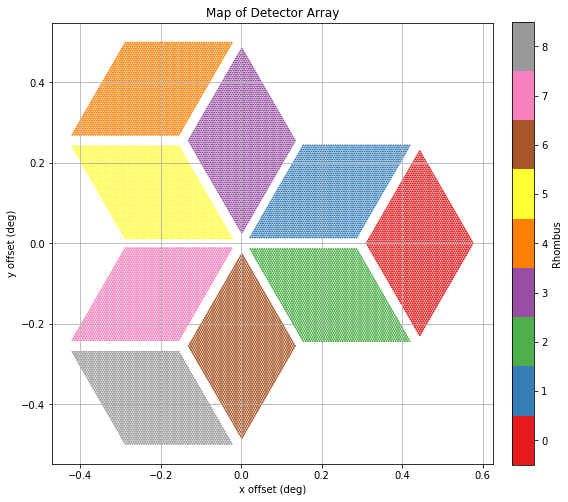

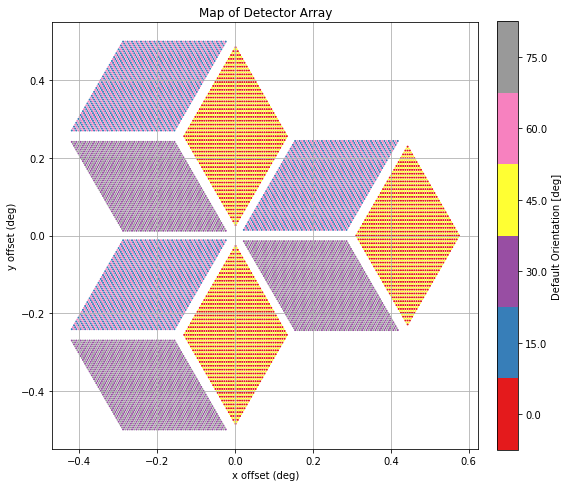

In [3]:
# you can create a module by passing in an F_lambda and a freq/wavelength 
mod1 = camera.Module(freq=550, F_lambda=1.1)
visualization.plot_module(mod1, mode='rhombus')
visualization.plot_module(mod1, mode='pol')

# there are a few pre-defined modules such as camera.CMBPol

In [4]:
# you can save the module data with specific columns 
mod1.save_data('mod1.csv', columns='all')
print(pd.read_csv('mod1.csv').head())

# you can pass it again in the future
mod2 = camera.Module('mod1.csv')

          x         y  pol  rhombus  wafer
0  0.311546  0.000000    0        0      0
1  0.314411  0.004962   45        0      0
2  0.317275  0.009924    0        0      0
3  0.320140  0.014886   45        0      0
4  0.323005  0.019848    0        0      0


### Creating an Instrument

In [5]:
# you can configure PrimeCam, ModCam, or an arbitrary Instrument object
# here, we create an empty PrimeCam instrument (default offset of (0, 0) and rotation of 0 deg)
prime_cam1 = camera.PrimeCam()
prime_cam1

instrument: offset [0. 0.] deg, rotation 0.0 deg
------------------------------------
empty

In [6]:
# add modules! change the instr offset/rotation!
prime_cam1.add_module(mod1, location=(1.78, 30), identifier='mod1') # location in terms of (dist, theta)
prime_cam1.add_module('CMBPol', 'i1') # a pre-defined module, location in terms of a pre-defined slot
prime_cam1.add_module('SFH', (0, 0), mod_rot=60)
prime_cam1.instr_offset = (1, 1)
prime_cam1

instrument: offset [1. 1.] deg, rotation 0.0 deg
------------------------------------
mod1 
 (r, theta) = (1.78, 30.0), rotation = 0.0
CMBPol 
 (r, theta) = (1.78, -90), rotation = 0.0
SFH 
 (r, theta) = (0.0, 0.0), rotation = 60.0

In [7]:
# change modules 
prime_cam1.change_module('mod1', new_mod_rot=30, new_location=(0, 0))
prime_cam1.change_module('mod1', new_identifier='mod2')

# delete modules
prime_cam1.delete_module('SFH')
prime_cam1

instrument: offset [1. 1.] deg, rotation 0.0 deg
------------------------------------
CMBPol 
 (r, theta) = (1.78, -90), rotation = 0.0
mod2 
 (r, theta) = (0.0, 0.0), rotation = 30.0

[  1.78 -90.  ] deg


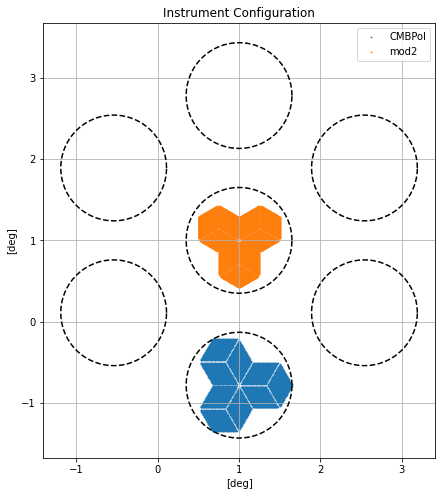

In [8]:
# get the Module object, location, and rotation of given module in the instrument e.g.
print(prime_cam1.get_location('CMBPol'))

# plot its configuration 
visualization.instrument_config(prime_cam1)

In [9]:
# save the configuration so that it can be used later 
prime_cam1.save_data('PrimeCam.json')
prime_cam2 = camera.PrimeCam('PrimeCam.json')

# Motion

In [10]:
from scanning import coordinates

### SkyPattern (path in RA/DEC)

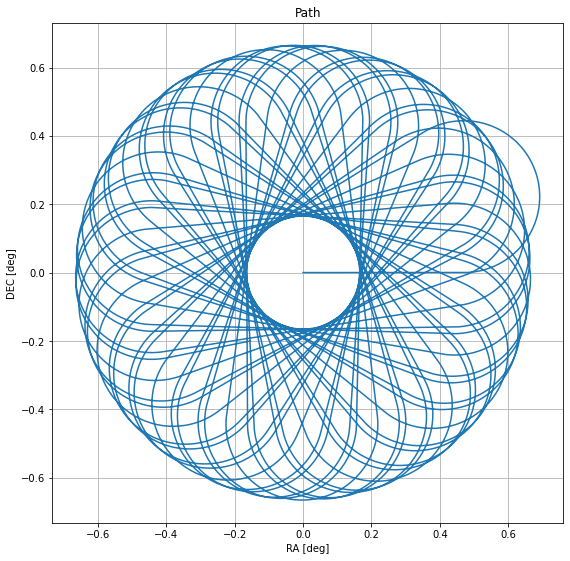

In [11]:
# Initialize a Daisy pattern by passing in keywords
daisy1 = coordinates.Daisy(
    velocity=1/3, start_acc=0.2, 
    R0=0.47, Rt=800*u.arcsec, Ra=600*u.arcsec, 
    T=300, sample_interval=1/400
)

visualization.sky_path(daisy1)

{'velocity': 0.3333333333333333, 'start_acc': 0.2, 'R0': 0.47, 'Rt': 0.2222222222222222, 'Ra': 0.16666666666666666, 'T': 300.0, 'sample_interval': 0.0025, 'y_offset': 0.0}


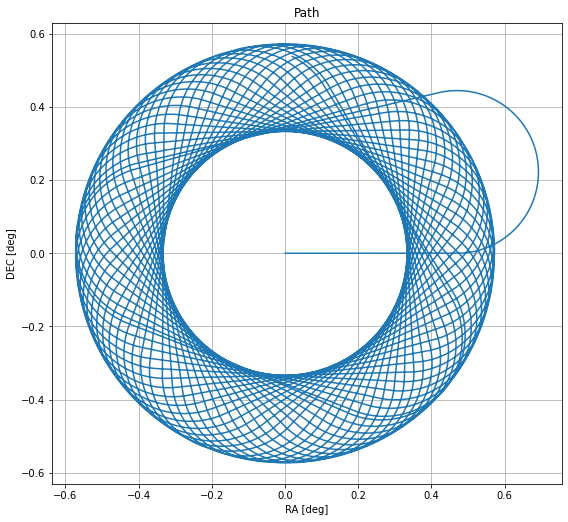

In [12]:
# You can save the parameters so that the same pattern can be used later
daisy1.save_param('Daisy.json')
with open('Daisy.json', 'r') as f:
    print(json.load(f))
    
daisy2 = coordinates.Daisy('Daisy.json', Ra=1200*u.arcsec) # you can use keywords to overwrite any parameters 
visualization.sky_path(daisy2)

In [13]:
# You can access its parameters and data as an attribute. For example:
print(daisy1.Ra)
print(daisy1.scan_duration)
print(daisy1.time_offset)
print(daisy1.x_coord)
print(daisy1.x_vel)
print(daisy1.vel)

0.16666666666666666 deg
300.0 s
[0.000000e+00 2.500000e-03 5.000000e-03 ... 2.999925e+02 2.999950e+02
 2.999975e+02] s
[ 1.25000000e-06  3.75000000e-06  7.50000000e-06 ... -1.55884371e-01
 -1.55067582e-01 -1.54250792e-01] deg
[0.001      0.00125    0.00175    ... 0.32671586 0.32671586 0.32671586] deg / s
[0.001     0.00125   0.00175   ... 0.3333344 0.3333344 0.3333344] deg / s


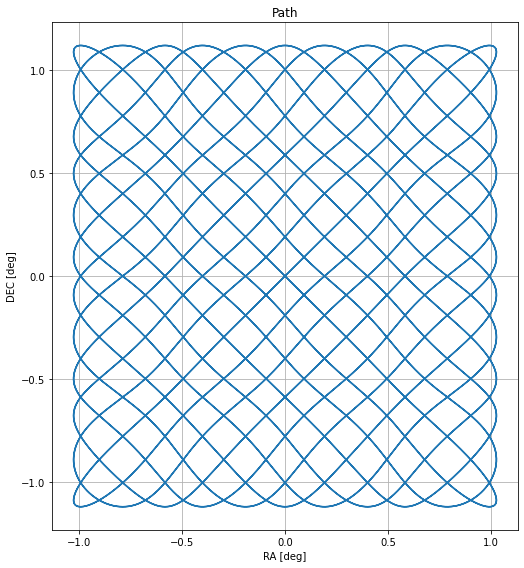

num_repeat = 2


In [14]:
# Similarly Initialize a Pong Pattern

# you can pass a max_scan_duration, which repeats the same pong pattern until the scan duration is less than max_scan_duration
# or you can directly pass num_repeat
pong1 = coordinates.Pong(
    num_term=4, 
    width=2, height=2, spacing='500 arcsec', 
    velocity=1/2, sample_interval=1/400,
    angle=0,
    max_scan_duration=360
)
visualization.sky_path(pong1)
print('num_repeat =', pong1.num_repeat)

In [15]:
# For any SkyPattern instance, you can save its data as a csv file 
# and specify any columns (default x_coord, y_coord, time_offset)
# Also specifiy whether to include repetitions for a repeatable pattern like Pong
pong1.save_data('Pong.csv', columns=['time_offset', 'x_coord', 'y_coord'], include_repeats=False) 
print(pd.read_csv('Pong.csv').head())

   time_offset   x_coord   y_coord
0       0.0000  0.000000  0.000000
1       0.0025  0.000815  0.000815
2       0.0050  0.001629  0.001629
3       0.0075  0.002444  0.002444
4       0.0100  0.003258  0.003258


In [16]:
# You can also create an arbitrary SkyPattern give time_offset, x_coord, and y_coord
# you can specify whether this is repeatable as well
sky_pattern1 = coordinates.SkyPattern('Pong.csv', repeatable=True, num_repeat=1)

### TelescopePattern (path in AZ/EL)

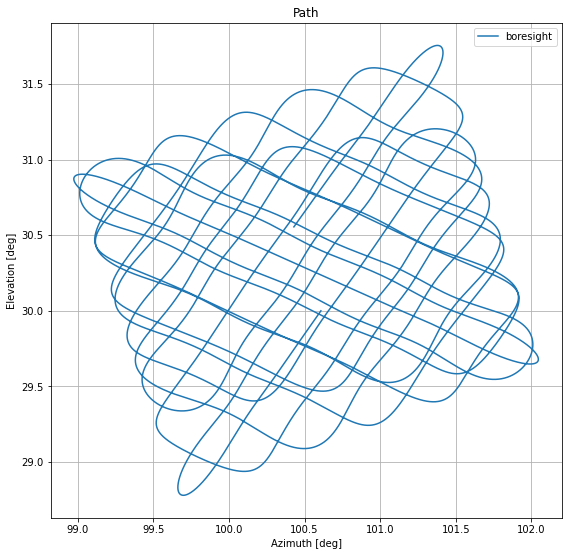

{'ra': 60.0, 'dec': -20.0, 'start_el': 30.0, 'location': {'lat': -22.985638888888893, 'lon': -67.7402777777778, 'height': 5611.800000000775}, 'moving_up': True}


In [17]:
# Initialize a TelescopePattern by passing a SkyPattern object
# Along with data of the observation, pass either a:
    # start_datetime
    # start_hrang (hourangle)
    # start_lst (sidereal time)
    # or start_el (with option to choose moving_up = True (default) or False)
    
t1 = coordinates.TelescopePattern(
    sky_pattern1, 
    ra=60, dec=-20, start_el=30
)
visualization.telescope_path(t1)

# save the parameters of this observation
t1.save_param('Observation.json')
with open('Observation.json', 'r') as f:
    print(json.load(f))

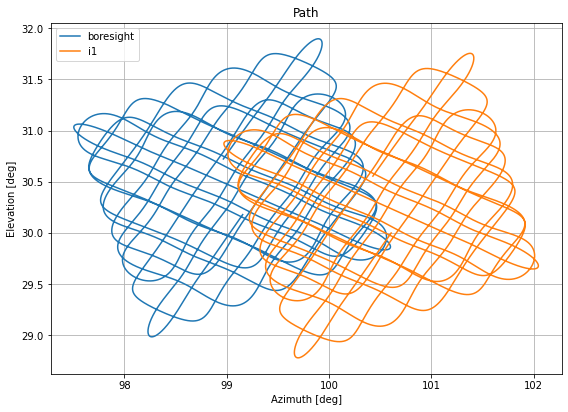

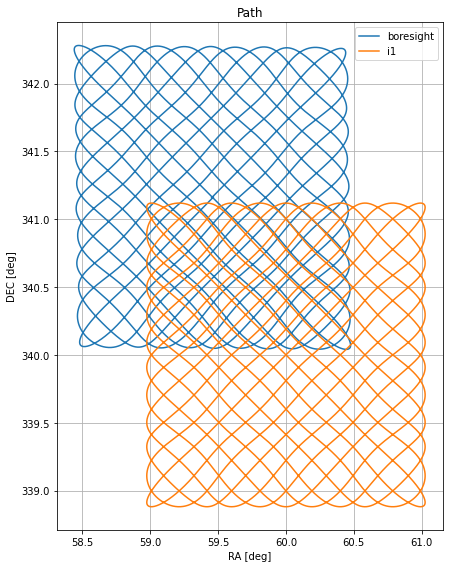

In [18]:
# Specify which module in a passed Instrument object to apply the pattern on 
# Also, you can pass these observation parameters into obs_param
t2 = coordinates.TelescopePattern(
    sky_pattern1, 
    instrument=prime_cam1, module='i1', 
    obs_param='Observation.json'
)
visualization.telescope_path(t2, module=['boresight', 'i1'])
visualization.sky_path(t2, module=['boresight', 'i1'])

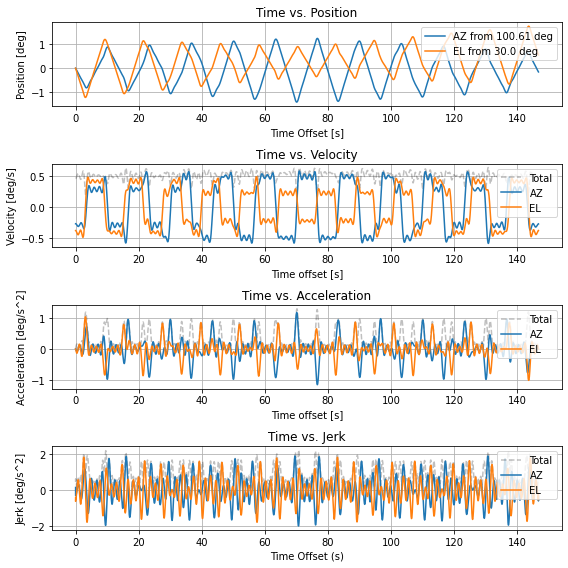

In [19]:
visualization.telescope_kinematics(t2, module='i1', plots=['coord', 'vel', 'acc', 'jerk'])

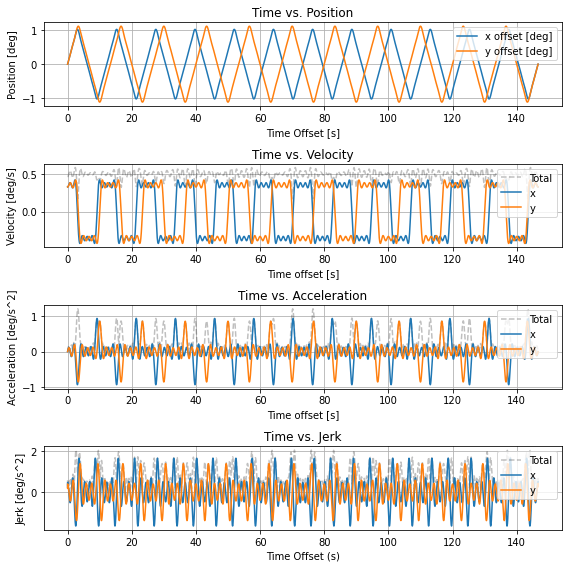

In [20]:
visualization.sky_kinematics(t2, module='i1', plots=['coord', 'vel', 'acc', 'jerk'])

-22d59m08.3s
[-0.32923571 -0.32923502 -0.32923432 ... -0.28838528 -0.28838459
 -0.28838389] hourangle
[0.0011588  0.0015534  0.00157855 ... 0.00511243 0.00346102 0.0021829 ] deg / s2
[-0.41996299 -0.55170352 -0.60517584 ... -0.49102201 -0.32433979
 -0.1927807 ] deg / s3
[19.70731044 19.70725881 19.70720717 ... 19.74737911 19.7473275
 19.74727589] hourangle
[59.45180765 59.45259265 59.45337766 ... 59.46353406 59.46431869
 59.46510331] deg
[253.80771079 253.80713222 253.80655367 ... 253.90679284 253.90620602
 253.90561923] deg


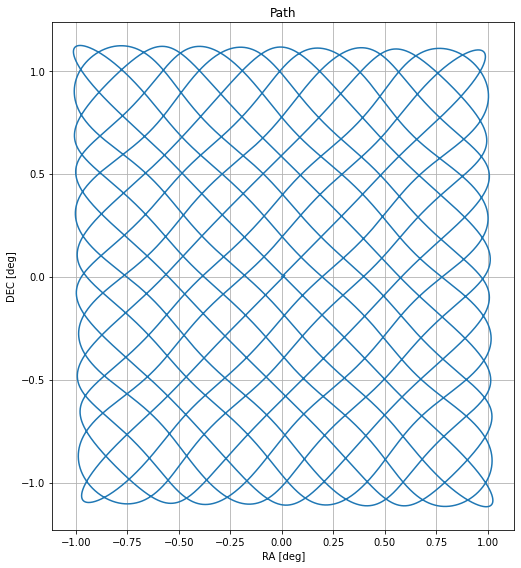

In [21]:
# You can access the boresight's parameters and data as an attribute. For example:
print(t2.location.lat)
print(t2.lst)
print(t2.az_acc)
print(t2.alt_jerk)
print(t2.hour_angle)
print(t2.ra_coord)
print(t2.para_angle)

# You can also get the boresight as a SkyPattern (recall it is in terms of x & y offset, not ra/dec)
sky_pattern_t2 = t2.get_sky_pattern()
visualization.sky_path(sky_pattern_t2)

In [22]:
# You get similar access of data for a different module.
# This returns a base TelescopePattern object (e.g. doesn't hold instrument info anymore)
t2_i1 = t2.view_module('i1')
print(t2_i1)

In [23]:
# you can also save the data to use again in the future
t2.save_data('TelescopePattern.csv', columns='default')
print(pd.read_csv('TelescopePattern.csv').head())

# this also shows how one can initialize a TelescopePattern given az/el coordinates
t3 = coordinates.TelescopePattern('TelescopePattern.csv')

# for all possible input combinatiosn to initialize a TelescopePattern, see doc strings

   time_offset       lst   az_coord  alt_coord    az_vel   alt_vel
0       0.0000 -0.329236  99.157184  30.179548 -0.261332 -0.370933
1       0.0025 -0.329235  99.156531  30.178620 -0.261329 -0.370937
2       0.0050 -0.329234  99.155877  30.177693 -0.261324 -0.370946
3       0.0075 -0.329234  99.155224  30.176766 -0.261321 -0.370958
4       0.0100 -0.329233  99.154571  30.175838 -0.261320 -0.370973


# Units and Saving Data

In [24]:
# when passing in values, there exists default units, but specific units can also be passed using astropy.units:
mod_unit = camera.Module(wavelength=0.0005*u.m)

# or as a string
mod_unit = camera.Module(wavelength='0.0005 m')

In [25]:
# most, if not all, classes have a save_data function:
# when saving data in json/csv format, not passing a path will make the function return a dictionary
mod_dict = mod1.save_data()
print(pd.DataFrame(mod_dict).head())

# when creating a class, you can pass a dict as "data" instead of a file name
mod_data = camera.Module(mod_dict)

          x         y  pol  rhombus  wafer
0  0.311546  0.000000    0        0      0
1  0.314411  0.004962   45        0      0
2  0.317275  0.009924    0        0      0
3  0.320140  0.014886   45        0      0
4  0.323005  0.019848    0        0      0


In [26]:
# all plotting functions have a "path" parameter that you can optionally use to save it
# and a "show_plot" function to display the plot on the screen (default True)
visualization.plot_module(mod_unit, path='Module.png', show_plot=False)

Saved to Module.png.
